# Feature Engineering

In [1]:
# dependencies - data manipulation
import pandas as pd
import numpy as np
import pickle
from itertools import combinations
from collections import Counter
from urllib.parse import unquote

# feature engineering
import re   # regular expressions
from tld import get_tld  # top level domain extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.stats import entropy
import fasttext  # embeddings

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# dimensionality reduction
from sklearn.decomposition import TruncatedSVD

# for association between two nominal variables
from scipy.stats.contingency import association

In [2]:
# load data from previous notebook
with open('../data/tmp_eda_full_df.pkl', 'rb') as f:
    df = pickle.load(f)

df.shape

(11711, 29)

In [3]:
df.head(1)

,datetime,region,browser,device,date,time,hour,__prefix__,n,f,...,ct,kl,kp,bkl,lsexp1,om,atb,atbva,va,atbexp
0,2019-12-02 00:00:01,Mercury,Safari,Android,2019-12-02,00:00:01,0,/ad_click,1,1,...,JP,wt-wt,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Broswer, region and device features

The plan is to apply one-hot encoding to `browser`, `region`, and `device` features, as these are low-cardinality categorical features with no imposed ordinal relationship (i.e., there is no meaningful order).

Although `browser` and `device` are moderately correlated, they will both be retained for now, as many algorithms handle such correlation well and dropping either prematurely could result in loss of potentially valuable signal.

In [4]:
cols = ['browser', 'device', 'region']
# drop_first=True avoids multicollinearity in linear models
one_hot_encoded = pd.get_dummies(df[cols], drop_first=True)

# combine with original DataFrame and drop original columns
df = pd.concat([df.drop(cols, axis=1), one_hot_encoded], axis=1)

# sanity check
df.columns

Index(['datetime', 'date', 'time', 'hour', '__prefix__', 'n', 'f', 'd', 'sld',
       'st', 'nt', 'r', 'adx', 'adx_name', 'ttc', 'q', 'ct', 'kl', 'kp', 'bkl',
       'lsexp1', 'om', 'atb', 'atbva', 'va', 'atbexp', 'browser_Chrome',
       'browser_Edge', 'browser_Safari', 'browser_UCBrowser', 'device_iOS',
       'region_Jupiter', 'region_Mars', 'region_Mercury', 'region_Saturn',
       'region_Venus'],
      dtype='object')

### Drop static columns

For the purpose of this exercise, features that have the same value in every row will be removed, as they contain no variance and therefore no signal -- models cannot learn anything from them.

However, in a real-world scenario, such features might be retained depending on their origin — for instance, if they come from a dynamic source, they may begin to vary over time and eventually carry predictive value.  
In this case, it will be assumed that dropping them is safe and does not risk losing relevant information.


In [5]:
constant_cols = df.columns[df.nunique(dropna=False) == 1].tolist()
print("Dropped constant columns:", constant_cols)

Dropped constant columns: ['date', '__prefix__', 'st']


In [6]:
# adding the datetime column as well, since date and time were split into separate columns
constant_cols += ["datetime"]

In [7]:
df.drop(columns=constant_cols, inplace=True)

### Handling Sparse, Imbalanced, and Correlated Features

From automated EDA report, it was easy to notice that the dataset contains multiple very sparse, imbalanced and some of them - very correlated between one another. Go through these variables to decide how to i


In [8]:
# hand-selected based on EDA report
sparse_columns = [
    'adx', 'atbva', 'bkl', 'lsexp1', 'n', 'nt', 'r', 'om', 'va',
    'f', 'adx_name', 'kp', 'sld', 'atbexp', 'atb'
]
sparse_df = df[sparse_columns].replace(['none', 'null'], np.nan)

In [9]:
sparse_df.describe()

,adx,atbva,bkl,lsexp1,n,nt,r,om,va,f,adx_name,kp,sld,atbexp,atb
count,1145,26,1521,1118,11711,11711,11474,372,6,11682,1,11711,11711,1,196
unique,3,5,50,2,2,2,3,2,3,1,1,3,2,1,1
top,def,k,r1-0,b,1,0,0,news:i:1,a,1,adsb,-1,0,uiu,REDACTED
freq,747,13,518,566,11710,11641,10811,336,4,11682,1,10550,7365,1,196


Overview of the above information with notes:

| Variable   | Unique Values | Most Frequent Value (%)  | Count (% present) | Notes                           |
| ---------- | ------------- | ------------------------ | ----------------- | ------------------------------- |
| `n`        | 2             | 11710 / 11711 (\~99.99%) | 100%              | Near-constant feature     |
| `nt`       | 2             | 11641 / 11711 (\~99.40%) | 100%              | Imbalanced, binary feaure                |
| `kp`       | 3             | 10550 / 11711 (\~90.1%)  | 100%              | Imbalanced, not sparse          |
| `sld`      | 2             | 7365 / 11711 (\~62.87%)  | 100%              | Well populated |
| `r`        | 3             | 10811 / 11474 (\~94.22%) | \~98%             | Imbalanced                      |
| `f`        | 1             | 11682 / 11682 (100%)     | \~99.8%           | Near-constant feature       |
| `bkl`      | 50            | 518 / 1521 (\~34.05%)    | \~13%             | Sparse, high cardinality        |
| `adx`      | 3             | 747 / 1145 (\~65.25%)    | \~10%             | Sparse                          |
| `lsexp1`   | 2             | 566 / 1118 (\~50.63%)    | \~10%             | Binary, sparse                  |
| `atb`      | 1             | 196 / 196 (100%)         | \~2%              | Constant & sparse - possible flag feature |
| `om`       | 2             | 336 / 372 (\~90.32%)     | \~3%              | Very sparse                     |
| `atbva`    | 5             | 13 / 26 (\~50%)          | \~0.2%            | Extremely sparse                |
| `va`       | 3             | 4 / 6 (\~66.67%)         | \~0.05%           | Extremely sparse                |
| `adx_name` | 1             | 1 / 1 (100%)             | \~0.01%           | Constant & very sparse          |
| `atbexp`   | 1             | 1 / 1 (100%)             | \~0.01%           | Constant & extremely sparse     |


---

### Feature Engineering Plan (Idea)

* Features that are either >99% constant or extremely sparse will be dropped, as they provide little to no signal.
* Imbalanced but well-populated features (e.g., `r`, `kp`, `sld`) will be one-hot encoded.
* The remaining sparse but potentially informative fields will be grouped and transformed using dimensionality reduction techniques (e.g., TruncatedSVD).



The plan: 
- Features that are either >99% constant or extremely sparse will be dropped, as they provide little to no signal.
- Imbalanced but well-populated features (e.g., r, kp, sld) will be one-hot encoded.
- The remaining sparse but potentially informative fields will be grouped and transformed using dimensionality reduction.

In [10]:
# drop features that are either >99% constant or extremely sparse
df.drop(columns=['n', 'f', 'adx_name', 'atbexp', 'va', 'atbva'], inplace=True)

In [11]:
# transform to binary features
df['nt'] = df['nt'].astype(int)

# trasnform with one-hot enncoding
# missing values will not be represented as a separate category,
# effectively treating them as absence of any known value.
r_encoded = pd.get_dummies(df['r'].replace('null', np.nan), prefix='r', dummy_na=False)
kp_encoded = pd.get_dummies(df['kp'], prefix='kp', dummy_na=False)
sld_encoded = pd.get_dummies(df['sld'], prefix='sld', dummy_na=False)
df = pd.concat([df.drop(['r', 'kp', 'sld'], axis=1), r_encoded], axis=1)


The remaining variables are highly sparse and lack clear definitions. While they might be encoded or excluded in a real-world setting, they will be retained to preserve potential signal.

To avoid excessive dimensionality from one-hot encoding, truncated singular value decomposition will be applied for dimensionality reduction. This method is preferred over PCA for sparse data, as noted in the scikit-learn documentation:
> Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.

In [12]:
combine_cols = ['lsexp1', 'om', 'adx', 'bkl', 'atb']

In [13]:
svd = TruncatedSVD(
    n_components=len(combine_cols), # must be less than or equal to the number of features
    random_state=42
)

# from categorical features to numerical via one-hot encoding
sparse_dummies = pd.get_dummies(
    df[combine_cols].replace('none', np.nan).fillna('NA'),
    prefix='sparse', 
    dummy_na=True
)

# reduce dimensionality
svd_features = svd.fit_transform(sparse_dummies)


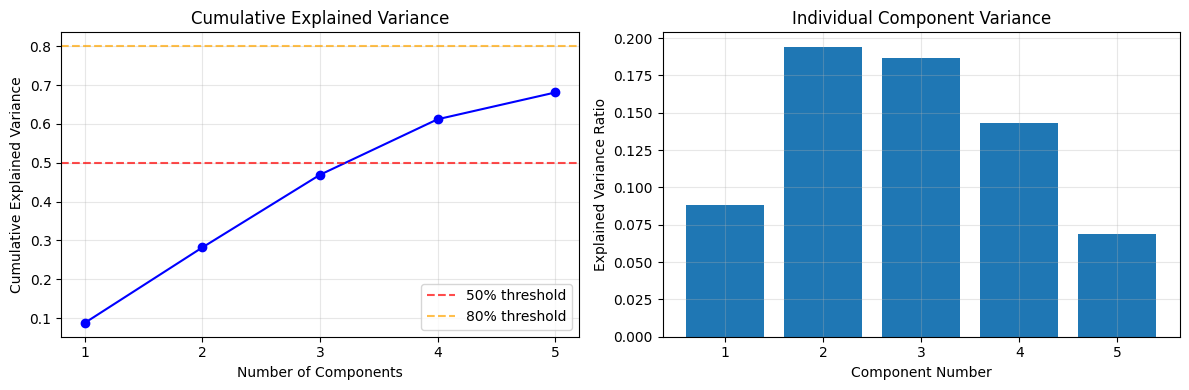

Components needed for 50% variance: 4
Components needed for 80% variance: Not reached


In [14]:
# Enhanced visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
x_ticks = range(1, len(combine_cols) + 1)

# Cumulative variance plot
cumulative_var = np.cumsum(svd.explained_variance_ratio_)
ax1.plot(range(1, len(cumulative_var) + 1), cumulative_var, 'bo-')
ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='50% threshold')
ax1.axhline(y=0.8, color='orange', linestyle='--', alpha=0.7, label='80% threshold')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Cumulative Explained Variance')
ax1.set_title('Cumulative Explained Variance')
ax1.set_xticks(x_ticks)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Individual variance plot
ax2.bar(range(1, len(svd.explained_variance_ratio_) + 1), svd.explained_variance_ratio_)
ax2.set_xlabel('Component Number')
ax2.set_ylabel('Explained Variance Ratio')
ax2.set_title('Individual Component Variance')
ax2.set_xticks(x_ticks)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

comp_50 = np.argmax(cumulative_var >= 0.5) + 1 if cumulative_var[-1] >= 0.5 else None
comp_80 = np.argmax(cumulative_var >= 0.8) + 1 if cumulative_var[-1] >= 0.8 else None

print(f"Components needed for 50% variance: {comp_50 if comp_50 else 'Not reached'}")
print(f"Components needed for 80% variance: {comp_80 if comp_80 else 'Not reached'}")

In [15]:
# Continue with 3 components, repeat previous steps
n_components = 4
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd_features = svd.fit_transform(sparse_dummies)

# Create DataFrame with exactly 3 components
svd_df = pd.DataFrame(
    svd_features, 
    columns=[f'sparse_{i}' for i in range(n_components)],
    index=df.index
)

In [16]:
df = pd.concat([df.drop(columns=combine_cols, axis=1), svd_df], axis=1)

### Time to click (`ttc`)

Time to click is generally a highly informative feature, but in its current form it is extremely skewed, with a long-tailed distribution and a wide range of values. To address this, a log transformation will be applied to reduce skewness, while preserving the influence of outliers by also bucketizing the values into quantiles ensuring that rare or extreme behaviors remain captured for anomaly detection.

In [17]:
df['ttc_log'] = np.log1p(df['ttc'].astype(float)) 

In [18]:
TTC_BINS = [-np.inf] + df['ttc'].astype(float).quantile([0.05, 0.25, 0.5, 0.75, 0.95]).tolist() + [np.inf]
TTC_LABELS = ['very_fast', 'fast', 'normal_fast', 'normal_slow', 'slow', 'very_slow']
TTC_LABELS_INTS = [0, 1, 2, 3, 4, 5]

df['ttc_bucket'] = pd.cut(df['ttc'].astype(float), bins=TTC_BINS, labels=TTC_LABELS_INTS)


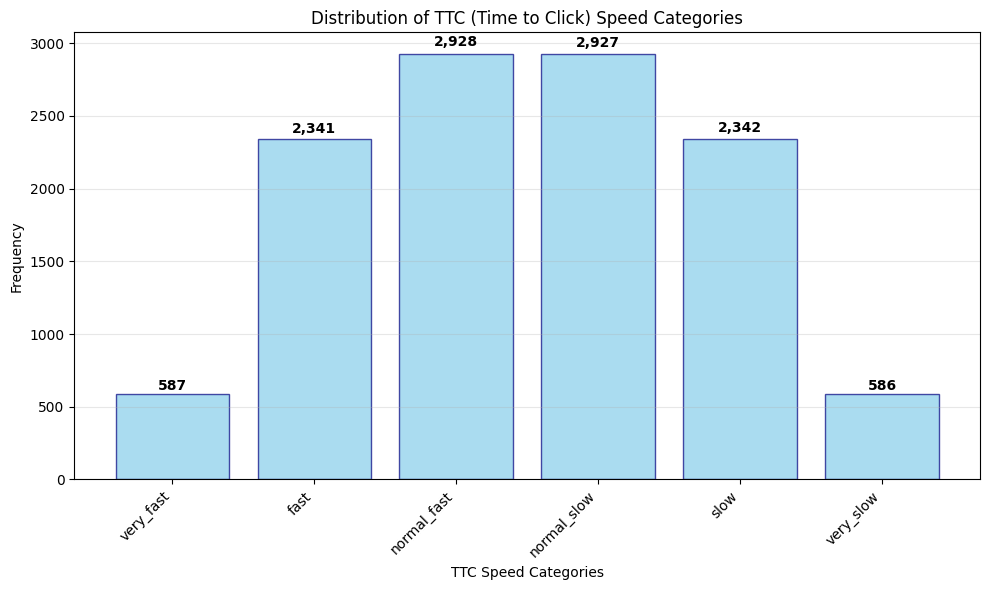

In [19]:
plt.figure(figsize=(10, 6))

# Count values in each bucket
bucket_counts = df['ttc_bucket'].value_counts()

# Reorder to match your label order
ordered_counts = bucket_counts.reindex(TTC_LABELS_INTS)

# Create bar plot (histogram of categorical data)
bars = plt.bar(range(len(ordered_counts)), ordered_counts.values,
               color='skyblue', edgecolor='navy', alpha=0.7)

# Customize the plot
plt.xlabel('TTC Speed Categories')
plt.ylabel('Frequency')
plt.title('Distribution of TTC (Time to Click) Speed Categories')
plt.xticks(range(len(ordered_counts)), TTC_LABELS, rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontweight='bold')

# Add grid for better readability
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
df.drop(columns=['ttc'], inplace=True)

### Country and Locale Codes (`ct`, `kl`)

Just based on values in these features `ct` appears to be country code, whereas `kl` - locale code (language, region). 

There are 143 unique values in the dataset, and in theory this number could grow further. Since one-hot encoding would create too many additional variables, frequency encoding will be used instead. Frequencies are calculated only from the training set and applied to validation and test sets via `.map()`. Unseen values are filled with 0, which helps highlight rare or previously unseen values — potentially useful for anomaly detection.

In [21]:
# check if all values are actually country codes
URL = 'https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/refs/heads/master/all/all.csv'
cc_df = pd.read_csv(URL)

In [22]:
is_country = df['ct'].isin(cc_df['alpha-2'].unique())
if not is_country.all():
    print(f'Country codes in data that are not valid: {",".join(df.loc[~is_country, 'ct'].unique())}')
    # replace with 'unknown'
    df.loc[~is_country, 'ct'] = 'unknown'

Country codes in data that are not valid: NA


In [23]:
CT_FREQ = df['ct'].value_counts(normalize=True)
df['ct_freq'] = df['ct'].map(CT_FREQ)

For locale code, it seems that the first part is country code and second - language code (for example, `mx-es`). In total there are 22 distinct values. Idea is to split this feature into two features and 

In [24]:
kl_df = df['kl'].str.split('-', expand=True)
kl_df.columns = ['country', 'language']

In [25]:
print(f"Unique country codes: {kl_df['country'].nunique()}")
print(f"Unique language codes: {kl_df['language'].nunique()}")

Unique country codes: 21
Unique language codes: 13


In [26]:
# countries that do not exist in country codes
kl_df.loc[~kl_df['country'].str.upper().isin(cc_df['alpha-2'].unique()), 'country'].unique()

# uk - could be though of united kingdom
# based on frequency, wt could be some internal default code

array(['wt', 'uk'], dtype=object)

In [27]:
# even though these are languages, most language codes would be the same as country codes
kl_df.loc[~kl_df['language'].str.upper().isin(cc_df['alpha-2'].unique()), 'language'].unique()

# en - english, da - danish
# based on frequency, wt could be some internal default code
# tzh however looks like a data quality issue

array(['wt', 'en', 'tzh', 'da'], dtype=object)

In [28]:
# quick check on combinations 
kl_df[kl_df['country'] != kl_df['language']].drop_duplicates()

# from this we see that tzh comes from taiwan and most likely is data quality
# issue as it is supposed to be zh

,country,language
4,uk,en
12,mx,es
52,in,en
96,ca,en
106,at,de
256,sg,en
307,us,en
413,hk,tzh
694,se,sv
867,br,pt


In [29]:
# fixing data quality based on observations
kl_df.loc[kl_df['country'] == 'uk', 'country'] = 'gb'
kl_df.loc[kl_df['language'] == 'tzh', 'language'] = 'zh'

In [30]:
# quick sanity check to see both country columns side by side
country_df = pd.concat([df['ct'], kl_df['country'], kl_df['language']], axis=1)
country_df['country'] = country_df['country'].str.upper()


In [31]:
combinations = list(combinations(country_df.columns, 2))
for combo in combinations:
    res = association(pd.crosstab(country_df[combo[0]], country_df[combo[1]]), method='cramer')
    print(f"Correlation between {combo[0]} and {combo[1]}: {res:0.2f}")

Correlation between ct and country: 0.49
Correlation between ct and language: 0.52
Correlation between country and language: 1.00


Since `country` and `language` extracted from the locale code are perfectly correlated, `country` will be dropped, as this information is theoretically already provided by the ct (country code) feature.

In [32]:
LANG_FREQ = country_df['language'].value_counts(normalize=True)
country_df['lang_freq'] = country_df['language'].map(LANG_FREQ)

In [33]:
df = pd.concat([df, country_df['lang_freq']], axis=1)
df.drop(columns=['ct', 'kl'], inplace=True)

### Ad domain features

Several domain-based features will be extracted from the URL data to capture patterns that might indicate click behavior. These include both - more basic features like lenght or numeric character ratio to more specific and embeddings.

For deeper semantic understanding, [FastText embeddings](https://fasttext.cc/docs/en/english-vectors.html) will be utilized. FastText was selected over other embedding models for two key reasons:
- Speed: FastText is significantly faster than alternatives like Word2Vec or BERT
- Character-level approach: FastText uses character n-grams to build word vectors, making it ideal for domain names that might be:
    * Made-up or brand-specific (e.g., googlex123.com)
    * In different languages
    * Contain typos or variations
This character-level approach is particularly valuable for domain analysis since domain names can be arbitrary strings that don't follow standard word patterns. Traditional n-gram approaches would create extremely sparse features, and linear dimensionality reduction wouldn't capture enough variance effectively.

**Trade-off**: While FastText embeddings provide rich semantic information, they are less interpretable than basic features. This is why both approaches are included in parallel - the basic features provide explainability while embeddings capture complex patterns.

In [34]:
from tld.exceptions import TldBadUrl
from typing import Optional

def fix_domain(subdomain: str) -> Optional[str]:
    """
    Removes 'www.' or 'www' from the start of a (sub)domain string.
    Removes the whole string if it's just 'www(.)'.
    Returns None if the result is empty or input is not a string.
    """
    if not isinstance(subdomain, str):
        return None
    out = subdomain.lstrip().removeprefix('www.').removeprefix('www').strip('.')
    return out if out else None

def get_url_parts(url: str) -> dict[str, Optional[str]]:
    """
    Extracts the domain, subdomain, and extension from a URL.
    """
    try:
        res = get_tld(url, as_object=True, fix_protocol=True)
        return {
            'domain': fix_domain(res.domain),
            'subdomain': fix_domain(res.subdomain),
            'extension': res.extension,
        }
    except TldBadUrl:
        return {}

In [35]:
# extract domain, subdomain, and extension from the url
domain_df = df['d'].str.lower().apply(get_url_parts).apply(pd.Series)

In [36]:
def entropy_scipy(s: str) -> float:
    """
    Measures how "random" or "unpredictable" a string of characters is.
    Higher number - more random.
    
    "aaaaaaaa" → Very low entropy
    "hellohello" → Low entropy (repetitive)
    "x7k9m2p4" → High entropy (random characters)
    "qwertyuiop" → Medium entropy (keyboard pattern)
    """
    if not s:
        return 0.0
    counts = Counter(s)
    probs = np.array(list(counts.values())) / len(s)
    return entropy(probs, base=2)  # Use log base 2 for bits

domain_df['domain_entropy'] = domain_df['domain'].apply(entropy_scipy)

In [37]:
# length of the domain
domain_df['domain_length'] = domain_df['domain'].str.len()

# ratio of digits in the domain in comparison to the length of the domain
domain_df['domain_digit_ratio'] = domain_df['domain'].str.count(r'\d').div(domain_df['domain'].str.len())

In [38]:
domain_df['domain'].fillna('')

ft = fasttext.load_model('../models/cc.en.300.bin')
domain_embeddings = domain_df['domain'].fillna('').apply(lambda x: ft.get_word_vector(x))
domain_matrix = np.vstack(domain_embeddings.values) 
domain_embedding_df = pd.DataFrame(domain_matrix, index=domain_df.index) 
domain_embedding_df.columns = [f'domain_ft_dim_{i}' for i in range(domain_embedding_df.shape[1])]

In [39]:
# For subdomain, a bit easier features
domain_df['has_subdomain'] = ~domain_df['subdomain'].isna()
domain_df['subdomain_entropy'] = domain_df['subdomain'].apply(entropy_scipy)

In [40]:
# For extension, we can use the same approach as for domain

# looking into extension, we see that sometimes there are two extensions, separated by a dot
# co.uk would be expected, whereas mx.com would not, however not really against the rules
# one discussion https://www.reddit.com/r/answers/comments/9afyl1/why_does_the_uk_use_couk_and_not_just_uk/


domain_df['extension_more_than_one'] = domain_df['extension'].str.count('\\.') > 0
domain_df['extension_entropy'] = domain_df['extension'].apply(entropy_scipy)

country_codes_list = cc_df['alpha-2'].str.lower().values
domain_df['has_country_tld'] = domain_df['extension'].str.split(".").apply(
    lambda x: any(elem in country_codes_list for elem in x)
)


In [41]:
domain_df.head(1)

,domain,subdomain,extension,domain_entropy,domain_length,domain_digit_ratio,has_subdomain,subdomain_entropy,extension_more_than_one,extension_entropy,has_country_tld
0,ashtondrake,None,com,3.277613,11.0,0.0,False,0.0,False,1.584963,False


In [42]:
df = pd.concat(
    [
        df.drop('d', axis=1), 
        domain_df.drop(['domain', 'subdomain', 'extension'], axis=1), 
        domain_embedding_df
    ], 
    axis=1)

### Search query

Essentially the same approach as it was for ad domain feature.

In [43]:
q_df = pd.DataFrame(index=df.index)

# Decode URL-encoded characters
q_df['q_decoded'] = df['q'].apply(lambda x: unquote(x) if pd.notna(x) else x)


In [44]:
# length and entropy of the query
q_df['q_length'] = q_df['q_decoded'].str.len()
q_df['q_entropy'] = q_df['q_decoded'].apply(entropy_scipy)
q_df['q_word_count'] = q_df['q_decoded'].str.split().apply(len)

# everything but letters and speces, e.g., digits, punctuation, etc.
q_df['q_symbol_ratio'] = q_df['q_decoded'].str.count(r'[^a-zA-Z ]').div(q_df['q_decoded'].str.len())

Classic word embedding - FastText:
- Handles typos and made-up words
- fastText breaks words into character n-grams and builds word vectors from these.
    - even if a word is new or misspelled, its n-grams are likely seen before, and it can generate a meaningful vector.

In [45]:
ft_embeddings = q_df['q_decoded'].apply(lambda x: ft.get_word_vector(x))
ft_matrix = np.vstack(ft_embeddings.values)
ft_df = pd.DataFrame(ft_matrix, index=q_df.index) 
ft_df.columns = [f'q_ft_dim_{i}' for i in range(ft_df.shape[1])]

In [46]:
df = pd.concat([df.drop('q', axis=1), q_df,ft_df], axis=1)

### Final

In [47]:
df.drop(columns=['time'], inplace=True)

In [48]:
# pass final state of dataframe to the next notebook
with open('../data/tmp_feature_engineering_df.pkl', 'wb') as f:
    pickle.dump(df, f)

All constants, thresholds, and configuration values have now been moved to a dedicated configuration file for better maintainability, clarity and reproducability.

Additionally, the feature engineering transformations developed in this notebook have been refactored and consolidated into a reusable pipeline, now located in `../transform.py`. 